### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

# Anomaly Detection for Digital Twin

- <a href='#configoci'>Config OCI Python SDK</a><br>
- <a href='#loadtraining'>Load training csv</a><br>
- <a href='#exploredata'>Exploring Data</a><br>
- <a href='#uploadtraining'>Upload training csv to object storage</a><br>
- <a href='#createADproject'>Create Anomaly Detection Project and Dataset using SDK</a><br>
- <a href='#createADmodel'>Create Anomaly Detection model training using SDK</a><br>
- <a href='#loadtestdata'>Load testing data from local</a><br>
- <a href='#modelinference'>Model inference using SDK</a><br>
- <a href='#modelinferenceconsole'>Model inference using console - Optional</a><br> 

In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from datetime import date
import random
import json
from matplotlib.pyplot import figure

%matplotlib inline

In [2]:
import oci
import time

from oci.config import from_file
from oci.ai_anomaly_detection.models import *
from oci.ai_anomaly_detection.anomaly_detection_client import AnomalyDetectionClient

from oci.ai_anomaly_detection.models.create_project_details import CreateProjectDetails
from oci.ai_anomaly_detection.models.create_data_asset_details import CreateDataAssetDetails
from oci.ai_anomaly_detection.models.data_source_details import DataSourceDetails
from oci.ai_anomaly_detection.models.data_source_details_object_storage import DataSourceDetailsObjectStorage

from oci.ai_anomaly_detection.models.create_model_details import CreateModelDetails
from oci.ai_anomaly_detection.models.model_training_details import ModelTrainingDetails

from oci.ai_anomaly_detection.models.data_item import DataItem
from oci.ai_anomaly_detection.models.inline_detect_anomalies_request import InlineDetectAnomaliesRequest

<a id='configoci'></a>
# Config OCI Python SDK

Please use this documentation for more details of OCI Python SDK configuration: https://oracle-cloud-infrastructure-python-sdk.readthedocs.io/en/latest/configuration.html

In [23]:
# os.environ["TENANCY_OCID"]
# os.environ["NB_SESSION_COMPARTMENT_OCID"]

'ocid1.tenancy.oc1..aaaaaaaaiyavtwbz4kyu7g7b6wglllccbflmjx2lzk5nwpbme44mv54xu7dq'

In [25]:
CONFIG_FILENAME = "/home/datascience/.oci/config"                                              # Update config file path if needed
config = from_file(CONFIG_FILENAME)                                                            # update profile name if not using default   

In [29]:
# Initialize service client with default config file
object_storage_client = oci.object_storage.ObjectStorageClient(config)

# get namespace
namespace = object_storage_client.get_namespace().data

In [22]:
# change the following constants accordingly
# ## If using the instance in data science platform, please refer this page https://dzone.com/articles/quick-and-easy-configuration-of-oracle-data-scienc to setup the content of config file

NAMESPACE = object_storage_client.get_namespace().data                                                       # Need to Update properly if different
compartment_id = os.environ["NB_SESSION_COMPARTMENT_OCID"] # compartment ocid of the project, Need to Update properly if different

In [4]:
# Initialize Anomaly Detection service client

SERVICE_ENDPOINT="https://anomalydetection.aiservice.us-ashburn-1.oci.oraclecloud.com"         # Need to Update properly if different
ad_client = AnomalyDetectionClient(config, service_endpoint=SERVICE_ENDPOINT)

<a id='loadtraining'></a>
# Load training csv from Object Storage

In [32]:
import ads
from ads.common.auth import default_signer

ads.set_auth(auth="api_key", oci_config_location="~/.oci/config", profile="DEFAULT")
bucket_name = "YJY"                                                                    # update bucket name if needed
file_name = "DigitalTwin/train.csv"                                                    # update file name if needed
training_df = pd.read_csv(f"oci://{bucket_name}@{NAMESPACE}/{file_name}", storage_options=default_signer())

In [35]:
training_df

,timestamp,BOOM_CYL_POS_OUT,TELE_CYL_POS_OUT,PLATFORM_VZ__OUT,BOOM_CYL_PRESS_HE_OUT,BOOM_CYL_PRESS_RE_OUT,BOOM_CYL_VEL_OUT,BOOM_DCV_SPOOL_OUT,PUMP_POWER_OUT,PUMP_PRESS_OUT,TELE_CYL_PRESS_HE_OUT,TELE_CYL_PRESS_RE_OUT,TELE_CYL_VEL_OUT,TELE_DCV_SPOOL_OUT
0,2022-08-31T00:00:00Z,4.440892e-16,1.387779e-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
1,2022-08-31T00:01:00Z,-1.105574e-04,-1.049718e-06,-0.038781,134.000026,-0.005206,-0.006319,0.001108,4.320198,280.864462,1.496403,-0.002974,-3.186470e-04,-1.266401e-06
2,2022-08-31T00:02:00Z,-6.800812e-05,-1.642887e-07,0.056145,71.931551,0.010304,0.008578,0.105024,9.311583,281.326152,0.668483,0.001478,3.398180e-04,1.610197e-06
3,2022-08-31T00:03:00Z,-5.944809e-05,2.321785e-06,-0.043641,39.484080,0.762339,-0.006330,0.214019,5.266582,103.639863,-2.290400,0.011096,-1.706195e-04,-3.327086e-06
4,2022-08-31T00:04:00Z,-1.570415e-04,-1.533788e-06,0.007935,143.917974,2.091887,0.000700,0.329236,2.164691,31.585893,2.642220,-0.002310,-5.918196e-05,-1.402151e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,2022-08-31T15:15:00Z,8.054933e-01,-2.318601e-06,0.005038,86.678272,17.068908,0.000821,0.418597,29.960542,168.052553,16.537141,0.071996,3.150825e-06,1.554937e-05
916,2022-08-31T15:16:00Z,8.055138e-01,-2.133059e-06,-0.006260,84.024348,16.746116,-0.001011,0.415628,29.999858,167.688739,16.445894,0.073647,8.718811e-07,1.535154e-05
917,2022-08-31T15:17:00Z,8.053052e-01,-2.109819e-06,-0.015203,86.364750,16.605045,-0.002527,0.414997,29.998300,167.630795,16.558463,0.074717,-2.765422e-08,1.549504e-05
918,2022-08-31T15:18:00Z,8.051546e-01,-2.047897e-06,-0.000164,88.135068,16.780578,-0.000059,0.413893,30.000908,167.625388,16.622064,0.075925,1.508134e-06,1.560792e-05



# Load training csv from local - Optional

In [5]:
training_df = pd.read_csv('train.csv')
training_df

,BOOM_CYL_POS_OUT,TELE_CYL_POS_OUT,PLATFORM_VZ__OUT,BOOM_CYL_PRESS_HE_OUT,BOOM_CYL_PRESS_RE_OUT,BOOM_CYL_VEL_OUT,BOOM_DCV_SPOOL_OUT,PUMP_POWER_OUT,PUMP_PRESS_OUT,TELE_CYL_PRESS_HE_OUT,TELE_CYL_PRESS_RE_OUT,TELE_CYL_VEL_OUT,TELE_DCV_SPOOL_OUT
0,4.440892e-16,1.387779e-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
1,-1.105574e-04,-1.049718e-06,-0.038781,134.000026,-0.005206,-0.006319,0.001108,4.320198,280.864462,1.496403,-0.002974,-3.186470e-04,-1.266401e-06
2,-6.800812e-05,-1.642887e-07,0.056145,71.931551,0.010304,0.008578,0.105024,9.311583,281.326152,0.668483,0.001478,3.398180e-04,1.610197e-06
3,-5.944809e-05,2.321785e-06,-0.043641,39.484080,0.762339,-0.006330,0.214019,5.266582,103.639863,-2.290400,0.011096,-1.706195e-04,-3.327086e-06
4,-1.570415e-04,-1.533788e-06,0.007935,143.917974,2.091887,0.000700,0.329236,2.164691,31.585893,2.642220,-0.002310,-5.918196e-05,-1.402151e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,8.054933e-01,-2.318601e-06,0.005038,86.678272,17.068908,0.000821,0.418597,29.960542,168.052553,16.537141,0.071996,3.150825e-06,1.554937e-05
916,8.055138e-01,-2.133059e-06,-0.006260,84.024348,16.746116,-0.001011,0.415628,29.999858,167.688739,16.445894,0.073647,8.718811e-07,1.535154e-05
917,8.053052e-01,-2.109819e-06,-0.015203,86.364750,16.605045,-0.002527,0.414997,29.998300,167.630795,16.558463,0.074717,-2.765422e-08,1.549504e-05
918,8.051546e-01,-2.047897e-06,-0.000164,88.135068,16.780578,-0.000059,0.413893,30.000908,167.625388,16.622064,0.075925,1.508134e-06,1.560792e-05


<a id='exploredata'></a>
# Exploring Training Data

In [6]:
# add timestamp to training data

num_rows = len(training_df)
training_df.insert(0, 'timestamp', pd.date_range(start=date.today(), periods=num_rows, freq='min'))
training_df['timestamp'] = training_df['timestamp'].apply(lambda x: x.strftime('%Y-%m-%dT%H:%M:%SZ'))

In [7]:
training_df

,timestamp,BOOM_CYL_POS_OUT,TELE_CYL_POS_OUT,PLATFORM_VZ__OUT,BOOM_CYL_PRESS_HE_OUT,BOOM_CYL_PRESS_RE_OUT,BOOM_CYL_VEL_OUT,BOOM_DCV_SPOOL_OUT,PUMP_POWER_OUT,PUMP_PRESS_OUT,TELE_CYL_PRESS_HE_OUT,TELE_CYL_PRESS_RE_OUT,TELE_CYL_VEL_OUT,TELE_DCV_SPOOL_OUT
0,2022-08-31T00:00:00Z,4.440892e-16,1.387779e-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
1,2022-08-31T00:01:00Z,-1.105574e-04,-1.049718e-06,-0.038781,134.000026,-0.005206,-0.006319,0.001108,4.320198,280.864462,1.496403,-0.002974,-3.186470e-04,-1.266401e-06
2,2022-08-31T00:02:00Z,-6.800812e-05,-1.642887e-07,0.056145,71.931551,0.010304,0.008578,0.105024,9.311583,281.326152,0.668483,0.001478,3.398180e-04,1.610197e-06
3,2022-08-31T00:03:00Z,-5.944809e-05,2.321785e-06,-0.043641,39.484080,0.762339,-0.006330,0.214019,5.266582,103.639863,-2.290400,0.011096,-1.706195e-04,-3.327086e-06
4,2022-08-31T00:04:00Z,-1.570415e-04,-1.533788e-06,0.007935,143.917974,2.091887,0.000700,0.329236,2.164691,31.585893,2.642220,-0.002310,-5.918196e-05,-1.402151e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,2022-08-31T15:15:00Z,8.054933e-01,-2.318601e-06,0.005038,86.678272,17.068908,0.000821,0.418597,29.960542,168.052553,16.537141,0.071996,3.150825e-06,1.554937e-05
916,2022-08-31T15:16:00Z,8.055138e-01,-2.133059e-06,-0.006260,84.024348,16.746116,-0.001011,0.415628,29.999858,167.688739,16.445894,0.073647,8.718811e-07,1.535154e-05
917,2022-08-31T15:17:00Z,8.053052e-01,-2.109819e-06,-0.015203,86.364750,16.605045,-0.002527,0.414997,29.998300,167.630795,16.558463,0.074717,-2.765422e-08,1.549504e-05
918,2022-08-31T15:18:00Z,8.051546e-01,-2.047897e-06,-0.000164,88.135068,16.780578,-0.000059,0.413893,30.000908,167.625388,16.622064,0.075925,1.508134e-06,1.560792e-05


In [8]:
# check data quality 

training_df.describe()

,BOOM_CYL_POS_OUT,TELE_CYL_POS_OUT,PLATFORM_VZ__OUT,BOOM_CYL_PRESS_HE_OUT,BOOM_CYL_PRESS_RE_OUT,BOOM_CYL_VEL_OUT,BOOM_DCV_SPOOL_OUT,PUMP_POWER_OUT,PUMP_PRESS_OUT,TELE_CYL_PRESS_HE_OUT,TELE_CYL_PRESS_RE_OUT,TELE_CYL_VEL_OUT,TELE_DCV_SPOOL_OUT
count,920.000000,9.200000e+02,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,9.200000e+02
mean,0.431729,-2.416274e-06,0.522684,89.101947,13.679881,0.085454,0.485659,26.970042,149.490602,10.540800,0.033694,0.000016,1.411148e-05
std,0.268473,3.312620e-06,0.262800,25.348850,4.319318,0.043015,0.100210,7.184660,35.102837,7.731185,0.017833,0.000043,1.833485e-05
min,-0.001769,-1.344184e-05,-0.367060,0.000000,-0.005211,-0.060945,0.000000,0.000000,0.000000,-4.901770,-0.004650,-0.000332,-7.676950e-06
25%,0.201040,-4.530431e-06,0.610596,70.350463,13.371267,0.100735,0.471533,29.053922,147.153780,3.962199,0.019864,0.000011,2.113023e-08
50%,0.443011,-1.580223e-06,0.625224,88.692001,14.935709,0.101809,0.501561,29.530570,151.092033,10.495427,0.031911,0.000016,7.843278e-06
75%,0.674745,1.007552e-08,0.641664,106.945276,16.319281,0.104700,0.537639,29.871919,159.495452,16.035580,0.046167,0.000026,2.177221e-05
max,0.814768,5.186141e-06,0.912889,198.591409,18.092102,0.150080,0.646196,30.568348,281.326157,30.545597,0.079254,0.000340,7.812084e-05


In [9]:
# Checking non-missing value rates for each attributes

training_df.count() / len(training_df)

timestamp                1.0
BOOM_CYL_POS_OUT         1.0
TELE_CYL_POS_OUT         1.0
PLATFORM_VZ__OUT         1.0
BOOM_CYL_PRESS_HE_OUT    1.0
BOOM_CYL_PRESS_RE_OUT    1.0
BOOM_CYL_VEL_OUT         1.0
BOOM_DCV_SPOOL_OUT       1.0
PUMP_POWER_OUT           1.0
PUMP_PRESS_OUT           1.0
TELE_CYL_PRESS_HE_OUT    1.0
TELE_CYL_PRESS_RE_OUT    1.0
TELE_CYL_VEL_OUT         1.0
TELE_DCV_SPOOL_OUT       1.0
dtype: float64

array([[<AxesSubplot:title={'center':'BOOM_CYL_POS_OUT'}>,
        <AxesSubplot:title={'center':'TELE_CYL_POS_OUT'}>,
        <AxesSubplot:title={'center':'PLATFORM_VZ__OUT'}>,
        <AxesSubplot:title={'center':'BOOM_CYL_PRESS_HE_OUT'}>],
       [<AxesSubplot:title={'center':'BOOM_CYL_PRESS_RE_OUT'}>,
        <AxesSubplot:title={'center':'BOOM_CYL_VEL_OUT'}>,
        <AxesSubplot:title={'center':'BOOM_DCV_SPOOL_OUT'}>,
        <AxesSubplot:title={'center':'PUMP_POWER_OUT'}>],
       [<AxesSubplot:title={'center':'PUMP_PRESS_OUT'}>,
        <AxesSubplot:title={'center':'TELE_CYL_PRESS_HE_OUT'}>,
        <AxesSubplot:title={'center':'TELE_CYL_PRESS_RE_OUT'}>,
        <AxesSubplot:title={'center':'TELE_CYL_VEL_OUT'}>],
       [<AxesSubplot:title={'center':'TELE_DCV_SPOOL_OUT'}>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

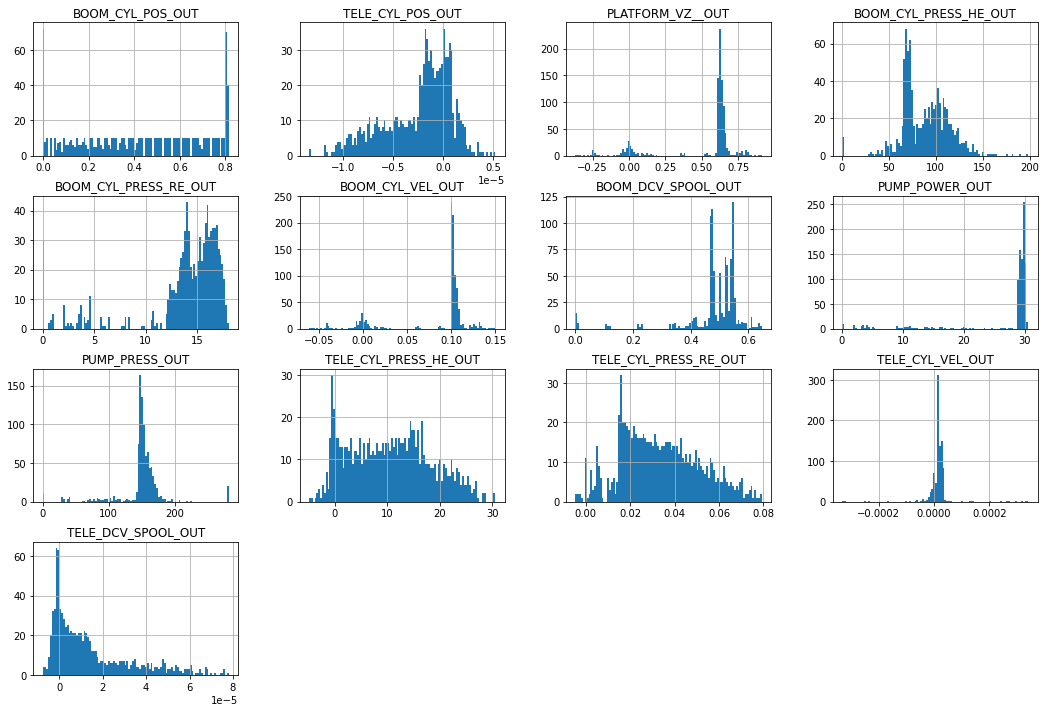

In [10]:
# Plot distributions of each signal 

output_cols = [e for e in training_df.columns if e != 'timestamp']
training_df[output_cols].hist(bins=100, figsize=(18, 12))

[]

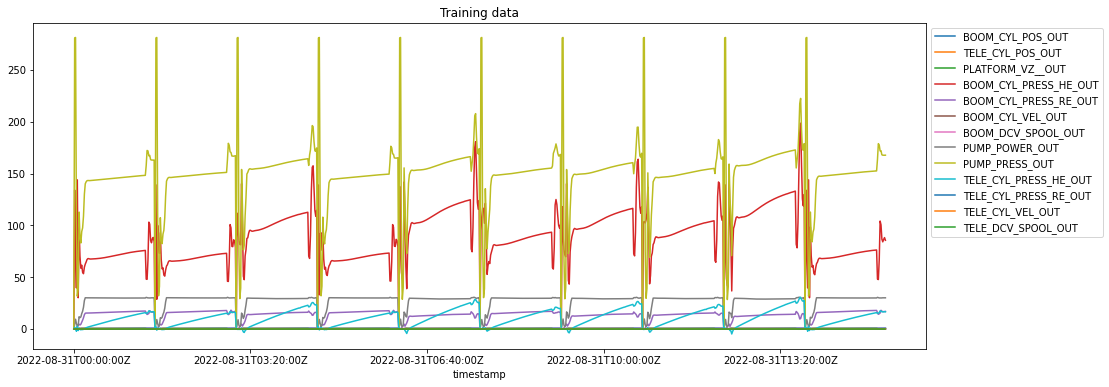

In [11]:
# plot all 13 signals

ax1 = training_df.plot(x='timestamp', figsize=(16,6))
ax1.set_title("Training data",color='black')
ax1.legend(bbox_to_anchor=(1.0, 1.0))
ax1.plot()

noticing 13 signals are having various data range, so plot signals seprately 

[]

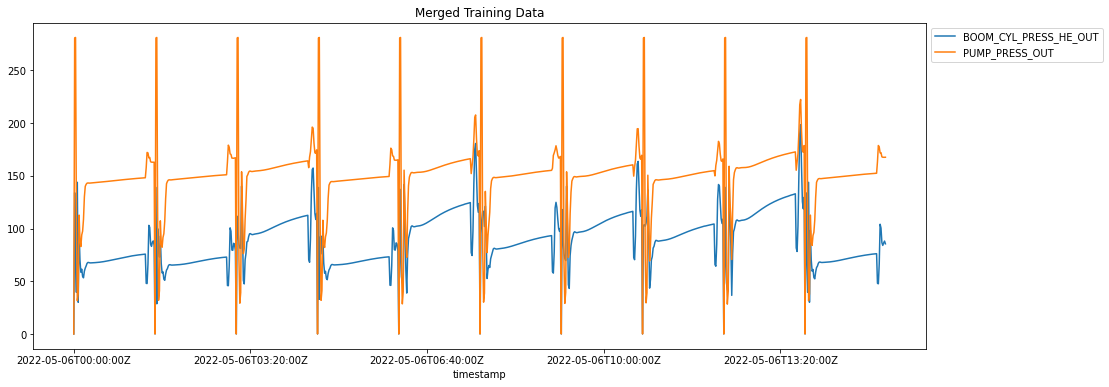

In [16]:
# plot ['BOOM_CYL_PRESS_HE_OUT', 'PUMP_PRESS_OUT'] in training data

signal_list1 = ['BOOM_CYL_PRESS_HE_OUT', 'PUMP_PRESS_OUT']
ax1 = training_df[signal_list1+['timestamp']].plot(x='timestamp', figsize=(16,6))
ax1.set_title("Merged Training Data",color='black')
ax1.legend(bbox_to_anchor=(1.0, 1.0))
ax1.plot()

[]

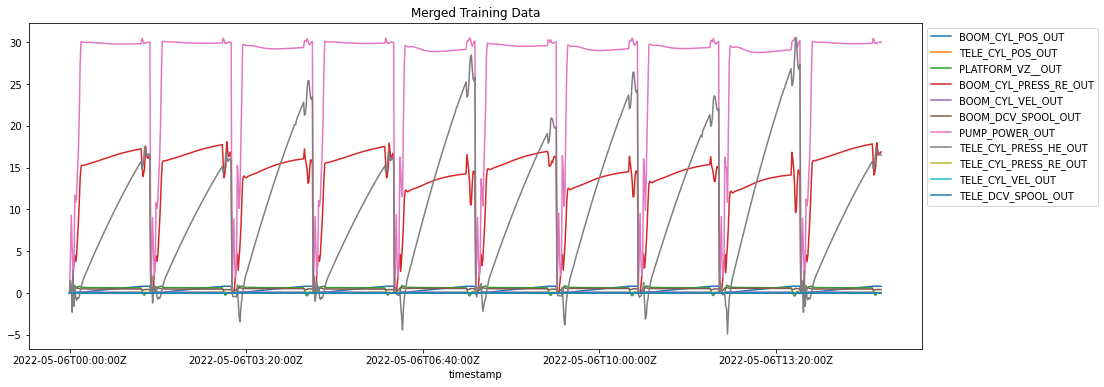

In [17]:
# plot signal without ['BOOM_CYL_PRESS_HE_OUT', 'PUMP_PRESS_OUT']

signal_list1 = ['BOOM_CYL_PRESS_HE_OUT', 'PUMP_PRESS_OUT']
ax1 = training_df.drop(columns = signal_list1).plot(x='timestamp', figsize=(16,6))
ax1.set_title("Merged Training Data",color='black')
ax1.legend(bbox_to_anchor=(1.0, 1.0))
ax1.plot()

[]

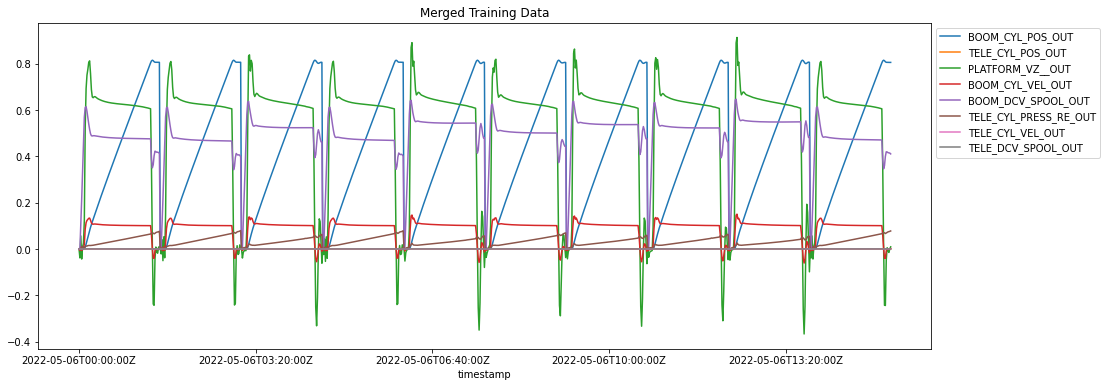

In [18]:
# plot without signal_list1&signal_list2 in merged training data

signal_list1 = ['BOOM_CYL_PRESS_HE_OUT', 'PUMP_PRESS_OUT']
signal_list2 = ['PUMP_POWER_OUT', 'BOOM_CYL_PRESS_RE_OUT', 'TELE_CYL_PRESS_HE_OUT']
ax1 = training_df.drop(columns=signal_list1+signal_list2).plot(x='timestamp', figsize=(16,6))
ax1.set_title("Merged Training Data",color='black')
ax1.legend(bbox_to_anchor=(1.0, 1.0))
ax1.plot()

[]

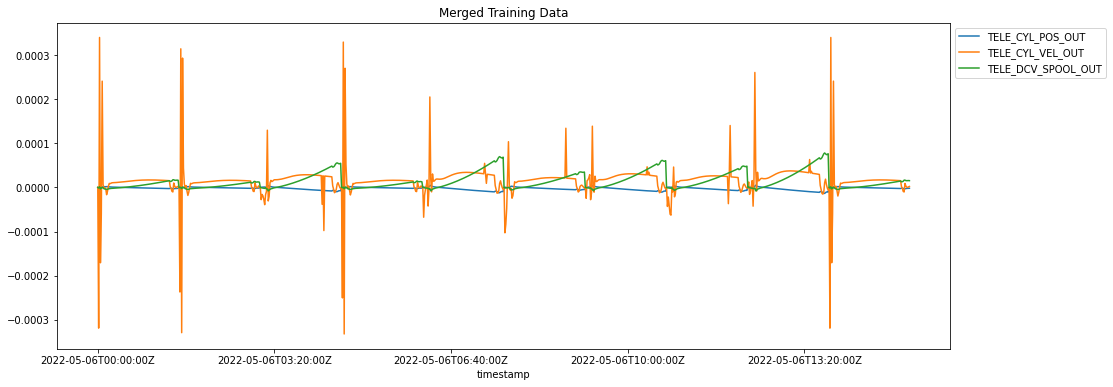

In [19]:
# plot rest signals 

signal_list3 = ['BOOM_CYL_POS_OUT', 'PLATFORM_VZ__OUT', 'BOOM_DCV_SPOOL_OUT', 'BOOM_CYL_VEL_OUT', 'TELE_CYL_PRESS_RE_OUT']
ax1 = training_df.drop(columns=signal_list1+signal_list2+signal_list3).plot(x='timestamp', figsize=(16,6))
ax1.set_title("Merged Training Data",color='black')
ax1.legend(bbox_to_anchor=(1.0, 1.0))
ax1.plot()

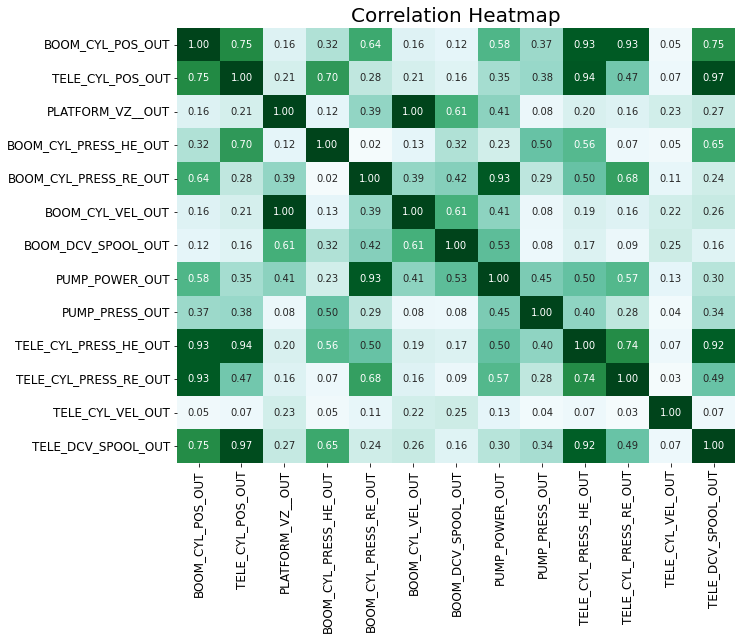

In [36]:
# Feature Correlation - optional to calculate correlations between the signals. This could potentially help identify data problems if any

import seaborn as sns
%matplotlib inline

corr = training_df.corr()

# plot the heatmap
plt.figure(figsize = (10, 8))

sns.heatmap(corr.abs(), cmap='BuGn', cbar=False, vmin=0, vmax=1, annot=True, fmt='.2f')
plt.xticks(rotation=90, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.title('Correlation Heatmap', fontsize=20)
plt.show()

One of OCI Anomaly Detection diffferentiators is Intelligent Data Preprocessing (IDP) that combines different data preprocessing techniques to resolve different data quality issues.<br>
* documentation: https://docs.oracle.com/en-us/iaas/Content/anomaly/using/overview.htm#ad-about

please using this live-lab for more advanced data preprocess: https://oracle.github.io/learning-library/oci-library/oci-hol/oci-artificial-intelligence/anomaly-detection/workshops/freetier/?lab=anomaly-detection-data-preprocessing#TASK2:ExploringData

### 
### Data Requirements

https://docs.oracle.com/en-us/iaas/Content/anomaly/using/data-require.htm

Training AND Testing


    - Each row represents one observation of those attributes, signals, and sensors at the given timestamp



<details>
<summary><font size="2">Training Data</font></summary>
    
- Can only contain timestamps and other numeric attributes that typically represent sensor or signal readings.
- Must be anomaly free (without outliers) and contain observations that have normal business conditions only.
- Covers all the normal business scenarios that contain the full value ranges on all attributes.
- Can be well related, belong to the same system or asset, or not. This is because the Anomaly Detection service uses both univariate and multivariate analysis methods.
</details>


<details>
<summary><font size="2">Detection (Testing) Data</font></summary>
    
- Can have anomaly data points
    
</details>

<details>
<summary><font size="2">Timestamp (optional)</font></summary>
    
- If including timestamp, timestamp column must be the first column with other numeric attributes, signals, and sensors following it.    
- The timestamp column is optional. Either the timestamp is provided for each value row or not given at all.
- If a timestamp column is provided, you must name it timestamp (all lowercase without any spaces) in the first column.
- The timestamps in the data are strictly increasing order and no duplicates
- The timestamps can have different frequencies. For example, 50 observations in one hour and 200 observation in the next hour.
- If no timestamp is given, then the data is assumed to be sorted chronologically by time.
    
</details>

<a id='uploadtraining'></a>
# Upload training csv to object storage - remove

In [13]:
from oci.object_storage.models import CreateBucketDetails
from oci.object_storage.models import CreatePreauthenticatedRequestDetails

# create Object Storage client
object_storage = oci.object_storage.ObjectStorageClient(config)

In [37]:
bucket_name="AnomalyDetection"        # change bucket_name perperly if different
object_name = 'train.csv'             

with open('/home/datascience/YJY/MapleSoft POC/DigitalTwin_demo/train.csv', 'rb') as f:       ## change the file path to where you have the train.csv stored
    object_text = object_storage.put_object(
        namespace_name = NAMESPACE,    
        bucket_name = bucket_name,
        object_name = object_name,
        put_object_body  = f)

<a id='createADproject'></a>
# Create Anomaly Detection Project and Dataset using SDK

In [168]:
# create Project 

print("-*-*-*-PROJECT-*-*-*-")

# CREATE CALL
proj_details = CreateProjectDetails(
    display_name="Digital Twin Project",
    description="Anomaly Detection project for Digital Twin",
    compartment_id=compartment_id,
)
create_res = ad_client.create_project(create_project_details=proj_details)
print("----CREATING----")
print(create_res.data)
time.sleep(5)
project_id = create_res.data.id

# GET CALL
get_proj = ad_client.get_project(project_id=project_id)
print("----READING---")
print(get_proj.data)
time.sleep(5)

-*-*-*-PROJECT-*-*-*-
----CREATING----
{
  "compartment_id": "ocid1.compartment.oc1..aaaaaaaacmg2hkfximygailkmeur7nribklqke35266kcrehx2pevxbh5gma",
  "defined_tags": {
    "Oracle-Tags": {
      "CreatedBy": "oracleidentitycloudservice/jiayuan.yang@oracle.com",
      "CreatedOn": "2022-05-05T19:36:45.146Z"
    }
  },
  "description": "Demo Project description",
  "display_name": "Demo Project",
  "freeform_tags": {},
  "id": "ocid1.aianomalydetectionproject.oc1.iad.amaaaaaawe6j4fqagemrxuanzdumwfngy7lrvhfldqvmadkbdxulwy63dx4q",
  "lifecycle_state": "ACTIVE",
  "system_tags": {},
  "time_created": "2022-05-05T19:36:45.404000+00:00",
  "time_updated": "2022-05-05T19:36:45.404000+00:00"
}
----READING---
{
  "compartment_id": "ocid1.compartment.oc1..aaaaaaaacmg2hkfximygailkmeur7nribklqke35266kcrehx2pevxbh5gma",
  "defined_tags": {
    "Oracle-Tags": {
      "CreatedBy": "oracleidentitycloudservice/jiayuan.yang@oracle.com",
      "CreatedOn": "2022-05-05T19:36:45.146Z"
    }
  },
  "descript

In [221]:
# Create Dataset

print("-*-*-*-DATA ASSET-*-*-*-")
# CREATE CALL
dDetails = DataSourceDetails(data_source_type="ORACLE_OBJECT_STORAGE")

dObjDeatils = DataSourceDetailsObjectStorage(
    namespace = NAMESPACE,
    bucket_name = bucket_name,
    object_name = object_name,
)

da_details = CreateDataAssetDetails(
    display_name = "AD DataAsset",
    description = "training dataset",
    compartment_id = compartment_id,
    project_id = project_id,
    data_source_details = dObjDeatils,
)
create_res = ad_client.create_data_asset(create_data_asset_details=da_details)
print("----CREATING----")
print(create_res.data)
time.sleep(5)
da_id = create_res.data.id

# READ CALL
get_da = ad_client.get_data_asset(data_asset_id=da_id)
print("----READING----")
print(get_da.data)
time.sleep(5)

-*-*-*-DATA ASSET-*-*-*-
----CREATING----
{
  "compartment_id": "ocid1.compartment.oc1..aaaaaaaacmg2hkfximygailkmeur7nribklqke35266kcrehx2pevxbh5gma",
  "data_source_details": {
    "bucket_name": "AnomalyDetection",
    "data_source_type": "ORACLE_OBJECT_STORAGE",
    "namespace": "orasenatdpltintegration03",
    "object_name": "train.csv"
  },
  "defined_tags": {
    "Oracle-Tags": {
      "CreatedBy": "oracleidentitycloudservice/jiayuan.yang@oracle.com",
      "CreatedOn": "2022-05-06T15:25:29.272Z"
    }
  },
  "description": "description DataAsset",
  "display_name": "Demo DataAsset",
  "freeform_tags": {},
  "id": "ocid1.aianomalydetectiondataasset.oc1.iad.amaaaaaawe6j4fqaisor67yhajoapoega5ye5jvwoggzorb3hustyynurawa",
  "lifecycle_state": "ACTIVE",
  "private_endpoint_id": null,
  "project_id": "ocid1.aianomalydetectionproject.oc1.iad.amaaaaaawe6j4fqagemrxuanzdumwfngy7lrvhfldqvmadkbdxulwy63dx4q",
  "system_tags": {
    "orcl-cloud": {
      "free-tier-retained": "true"
    }
  },

<a id='createADmodel'></a>
# Create Anomaly Detection model training using SDK

In [222]:
# create Model training

print("-*-*-*-MODEL-*-*-*-")
# CREATE CALL
dataAssetIds = [da_id]
mTrainDetails = ModelTrainingDetails(
    target_fap=0.02, training_fraction=0.7, data_asset_ids=dataAssetIds
)
mDetails = CreateModelDetails(
    display_name="Demo model",
    description="description Model",
    compartment_id=compartment_id,
    project_id=project_id,
    model_training_details=mTrainDetails,
)

create_res = ad_client.create_model(create_model_details=mDetails)
print("----CREATING----")
print(create_res.data)
time.sleep(60)
model_id = create_res.data.id

# READ CALL
get_model = ad_client.get_model(model_id=model_id)
print("----READING----")
print(get_model.data)
time.sleep(60)
while get_model.data.lifecycle_state == Model.LIFECYCLE_STATE_CREATING:
    get_model = ad_client.get_model(model_id=model_id)
    time.sleep(60)
    print(get_model.data.lifecycle_state)

-*-*-*-MODEL-*-*-*-
----CREATING----
{
  "compartment_id": "ocid1.compartment.oc1..aaaaaaaacmg2hkfximygailkmeur7nribklqke35266kcrehx2pevxbh5gma",
  "defined_tags": {
    "Oracle-Tags": {
      "CreatedBy": "oracleidentitycloudservice/jiayuan.yang@oracle.com",
      "CreatedOn": "2022-05-06T15:25:49.300Z"
    }
  },
  "description": "description Model",
  "display_name": "Demo model",
  "freeform_tags": {},
  "id": "ocid1.aianomalydetectionmodel.oc1.iad.amaaaaaawe6j4fqafmjl3dxs3ilchlaoy4c2zx4xhsrhoxm6wmadj2dgc7ca",
  "lifecycle_details": "none",
  "lifecycle_state": "CREATING",
  "model_training_details": {
    "data_asset_ids": [
      "ocid1.aianomalydetectiondataasset.oc1.iad.amaaaaaawe6j4fqaisor67yhajoapoega5ye5jvwoggzorb3hustyynurawa"
    ],
    "target_fap": 0.02,
    "training_fraction": 0.7
  },
  "model_training_results": null,
  "project_id": "ocid1.aianomalydetectionproject.oc1.iad.amaaaaaawe6j4fqagemrxuanzdumwfngy7lrvhfldqvmadkbdxulwy63dx4q",
  "system_tags": {},
  "time_cre

# 
When the output window prints ACTIVE, it means the model training has completed, you can check the trained model and view model details from Anomaly Detection service console.  

<a id='loadtestdata'></a>
# Load testing data from Object Storage

<a id='loadtestdata'></a>
# Load testing data from local - remove

In [16]:
# Load the data from a csv file with first column as timestamp
test_df = pd.read_csv('test_data.csv')
signalNames = [e for e in test_df.columns if e != 'timestamp']

print(signalNames)

['BOOM_CYL_POS_OUT', 'TELE_CYL_POS_OUT', 'PLATFORM_VZ__OUT', 'BOOM_CYL_PRESS_HE_OUT', 'BOOM_CYL_PRESS_RE_OUT', 'BOOM_CYL_VEL_OUT', 'BOOM_DCV_SPOOL_OUT', 'PUMP_POWER_OUT', 'PUMP_PRESS_OUT', 'TELE_CYL_PRESS_HE_OUT', 'TELE_CYL_PRESS_RE_OUT', 'TELE_CYL_VEL_OUT', 'TELE_DCV_SPOOL_OUT']


In [17]:
# print the shape of test dataframe and top 5 rows

print(test_df.shape)
test_df.head()

(92, 14)


,timestamp,BOOM_CYL_POS_OUT,TELE_CYL_POS_OUT,PLATFORM_VZ__OUT,BOOM_CYL_PRESS_HE_OUT,BOOM_CYL_PRESS_RE_OUT,BOOM_CYL_VEL_OUT,BOOM_DCV_SPOOL_OUT,PUMP_POWER_OUT,PUMP_PRESS_OUT,TELE_CYL_PRESS_HE_OUT,TELE_CYL_PRESS_RE_OUT,TELE_CYL_VEL_OUT,TELE_DCV_SPOOL_OUT
0,2022-05-05T00:00:00.000000,4.440000e-16,1.390000e-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
1,2022-05-05T00:00:00.100000,-9.191100e-04,2.430000e-07,-0.046987,125.297500,0.001228,-0.007653,0.009385,4.266420,280.864459,-0.123887,0.001654,-0.000027,-3.400000e-07
2,2022-05-05T00:00:00.200000,-1.291353e-03,6.610000e-07,-0.012836,81.223510,0.000171,-0.002055,0.117875,9.195673,281.326156,-0.363730,0.004434,0.000005,-8.980000e-07
3,2022-05-05T00:00:00.300000,-1.406889e-03,7.630000e-07,-0.003807,66.959054,0.948588,-0.000585,0.228862,3.380567,67.363949,-0.357251,0.005393,0.000014,-1.180000e-06
4,2022-05-05T00:00:00.400000,-1.445792e-03,8.400000e-07,-0.000228,62.007297,2.145117,-0.000004,0.344060,1.954083,28.872231,-0.369630,0.006046,0.000023,-1.350000e-06


<a id='modelinference'></a>
# Model inference using SDK

In [18]:
# Now create the Payload from the dataframe
from datetime import datetime

payloadData = []
for index, row in test_df.iterrows():
    timestamp = datetime.strptime(row['timestamp'], "%Y-%m-%dT%H:%M:%S.%f")
    values = list(row[signalNames])
    dItem = DataItem(timestamp=timestamp, values=values)
    payloadData.append(dItem)

In [19]:
# call AD model and detect

inline = InlineDetectAnomaliesRequest(model_id=model_id, request_type="INLINE", signal_names=signalNames, data=payloadData)

detect_res = ad_client.detect_anomalies(detect_anomalies_details=inline)
print("----DETECTING----")

NameError: name 'model_id' is not defined

The results return an array of anomalies grouped by timestamp. Each timestamp could have anomalies generated by single or multiple signals. Anomaly generated by one signal contains a tuple of signal name, actual value, estimate value, and an anomaly score with in the range of 0 to 1 that indicate the significance of anomaly. Meanwhile, each timestamp also have a normalized score that combines the significance scores across single or multiple alerted signals.

In [28]:
# # print anomalies results 

# print(detect_res.data)

<a id='modelinferenceconsole'></a>
# Model inference using console - Optional

Go to Anomaly Detection service console
</br><br>
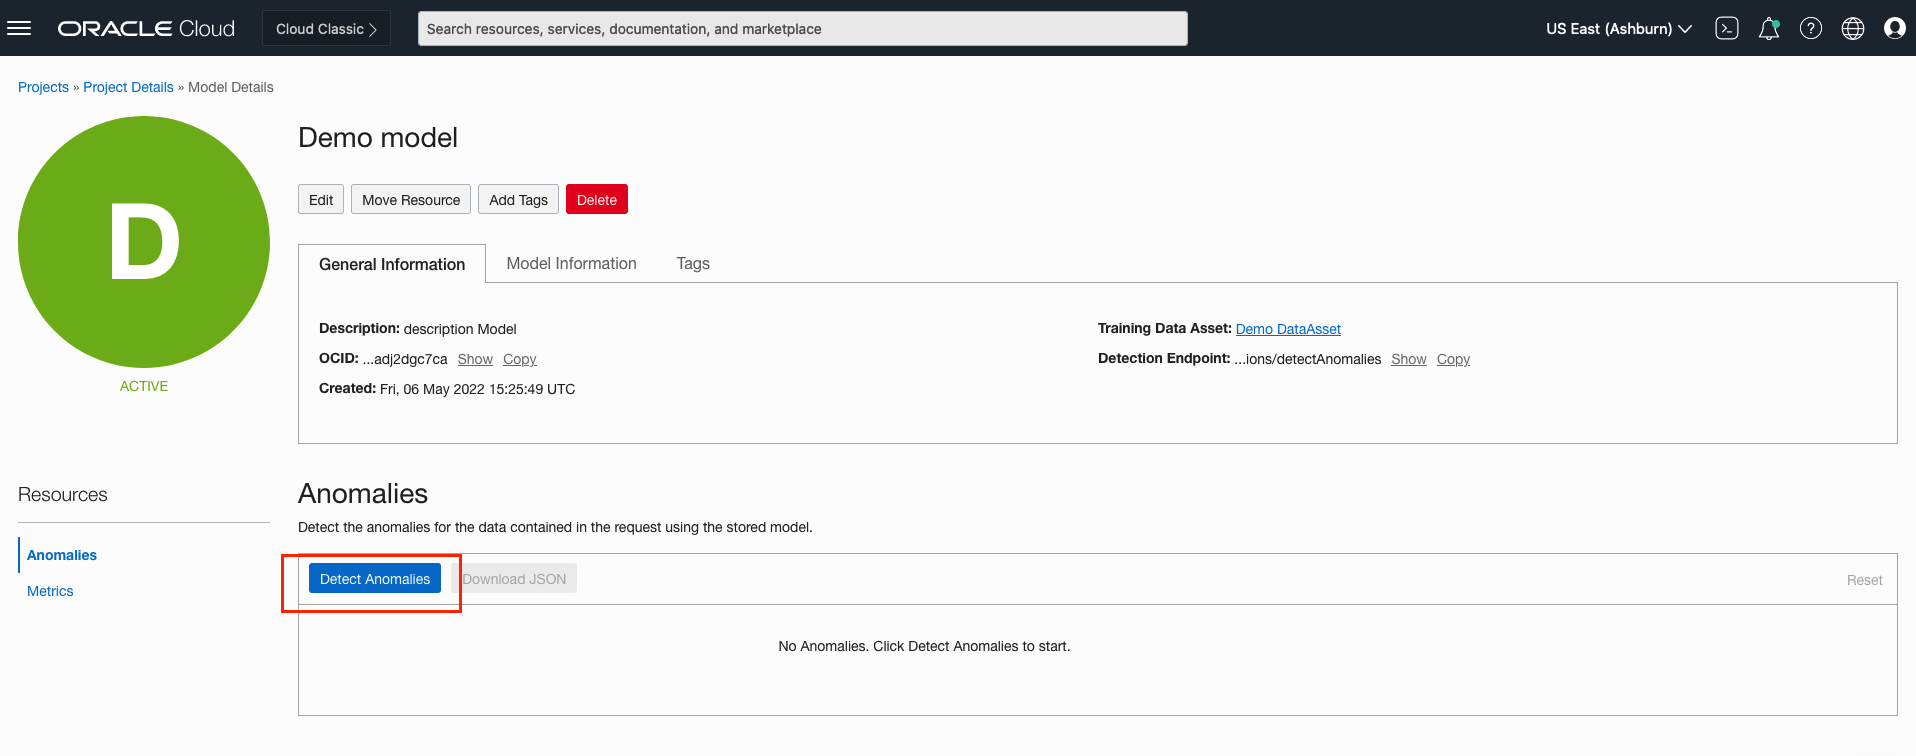

Select a file from local filesystem or drag and drop the desired file.<br>
<br>
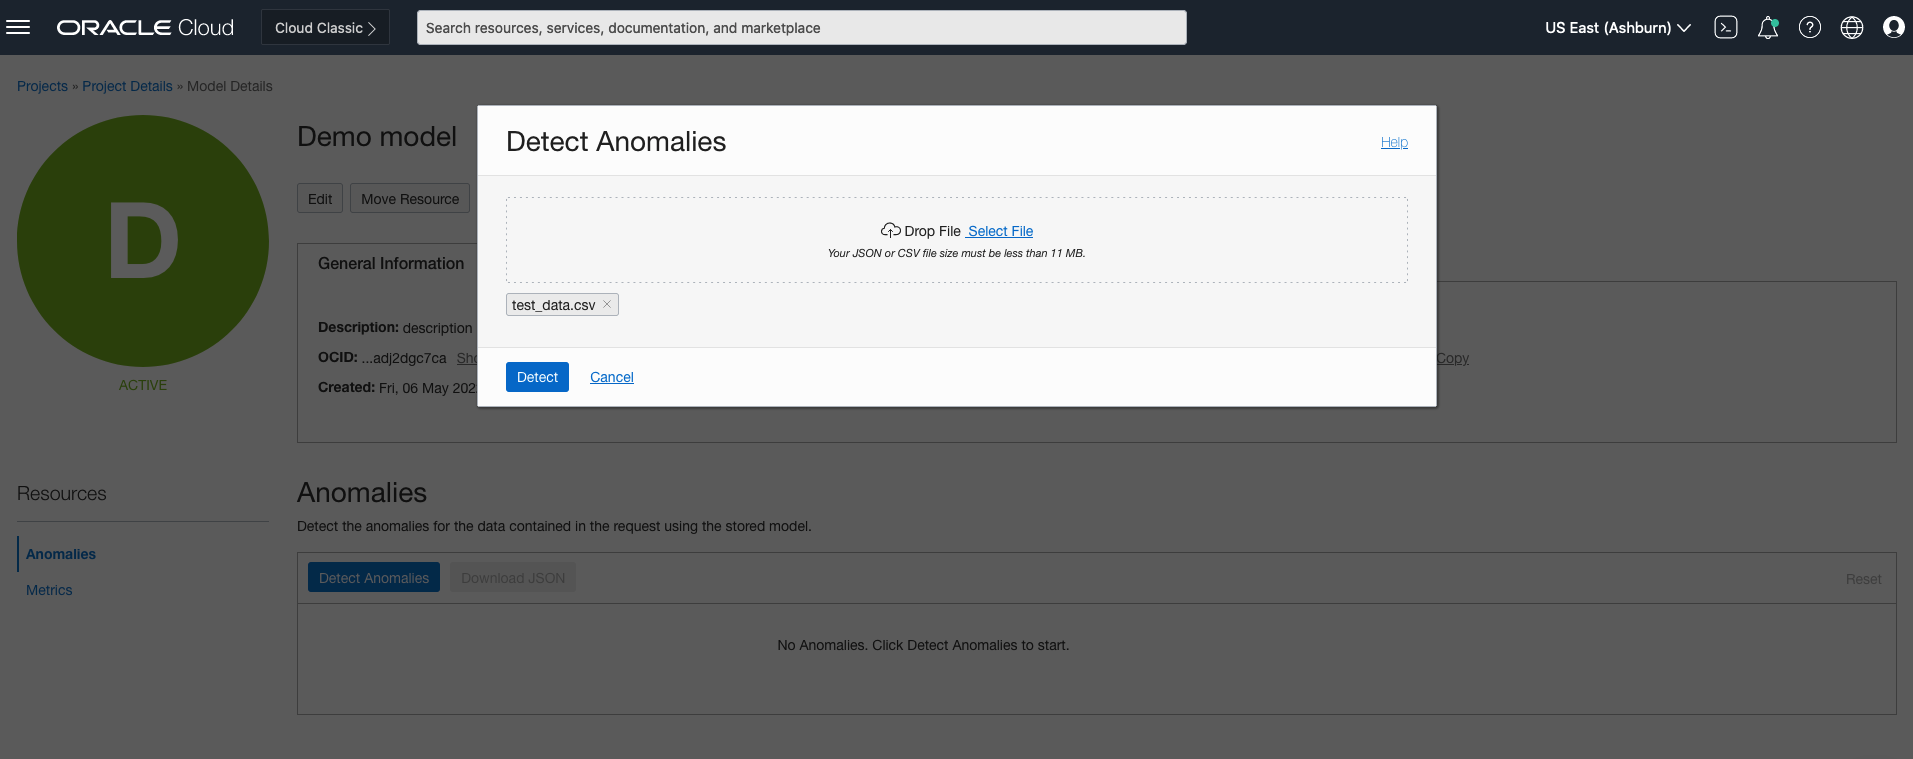